In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [79]:
import requests
import pandas as pd
from datetime import datetime, timedelta, date

base_url = 'https://api.energy-charts.info/'
country_code = 'ch'

def process_timestamps(unix_seconds):
    return [datetime.utcfromtimestamp(ts) for ts in unix_seconds]

def get_public_power():
    start_date = date(2023, 1, 1)
    end_date = date(2023, 12, 31)

    start_datetime = start_date.strftime('%Y-%m-%dT%H:%M:%S%z')
    end_datetime = end_date.strftime('%Y-%m-%dT%H:%M:%S%z')
    
    url = base_url + 'public_power'
    params = {
        'country': country_code,
        'start': start_datetime,
        'end': end_datetime
    }

    response = requests.get(url, params=params)
    if response.status_code != 200:
        print(f"Failed to retrieve data: {response.status_code} - {response.text}")
        return pd.DataFrame()

    data = response.json()
    timestamps = process_timestamps(data['unix_seconds'])
    production_data = data['production_types']

    df_list = []
    for entry in production_data:
        if entry['name'] == 'Solar':
            df = pd.DataFrame({
                'Time': timestamps,
                'Production Type': entry['name'],
                'Power (MW)': entry['data']
            })
            df_list.append(df)

    if not df_list:
        return pd.DataFrame()

    return pd.concat(df_list, ignore_index=True)

# Load data
df = get_public_power()

df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)
    

data = df['Power (MW)'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

print(df.head(25))


                    Production Type  Power (MW)
Time                                           
2023-01-01 00:00:00           Solar         0.0
2023-01-01 01:00:00           Solar         0.0
2023-01-01 02:00:00           Solar         0.0
2023-01-01 03:00:00           Solar         0.0
2023-01-01 04:00:00           Solar         0.0
2023-01-01 05:00:00           Solar         0.0
2023-01-01 06:00:00           Solar         0.0
2023-01-01 07:00:00           Solar         3.0
2023-01-01 08:00:00           Solar        74.3
2023-01-01 09:00:00           Solar       216.3
2023-01-01 10:00:00           Solar       646.8
2023-01-01 11:00:00           Solar       760.1
2023-01-01 12:00:00           Solar       766.5
2023-01-01 13:00:00           Solar       611.1
2023-01-01 14:00:00           Solar       283.4
2023-01-01 15:00:00           Solar        33.3
2023-01-01 16:00:00           Solar         0.0
2023-01-01 17:00:00           Solar         0.0
2023-01-01 18:00:00           Solar     

In [80]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_dataset(data, look_back=1):
    """
    Convert an array of values into a dataset matrix suitable for LSTM training.
    
    Parameters:
        data (array): The dataset array containing sequential data.
        look_back (int): Number of previous time steps to use as input variables to predict the next time period.
        
    Returns:
        X (array): Feature dataset.
        y (array): Labels.
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]  # Fetch the input data from the current index to the look_back length
        X.append(a)
        y.append(data[i + look_back, 0])  # The label will be the next data point
    return np.array(X), np.array(y)

# Assume 'data' is loaded and scaled as the 'Power (MW)' from your solar data.
# For example purposes, let's define 'data' here manually:
data = np.array([[i] for i in range(100)])  # Example data generation
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Define the look_back period
look_back = 24  # This means the input for each sample will be sequences of 3 past observations

# Create the dataset
X, y = create_dataset(data, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print("Sample of feature (X) and label (y):")
print("X[0]:", X[0])
print("y[0]:", y[0])

Sample of feature (X) and label (y):
X[0]: [[0.        ]
 [0.01010101]
 [0.02020202]
 [0.03030303]
 [0.04040404]
 [0.05050505]
 [0.06060606]
 [0.07070707]
 [0.08080808]
 [0.09090909]
 [0.1010101 ]
 [0.11111111]
 [0.12121212]
 [0.13131313]
 [0.14141414]
 [0.15151515]
 [0.16161616]
 [0.17171717]
 [0.18181818]
 [0.19191919]
 [0.2020202 ]
 [0.21212121]
 [0.22222222]
 [0.23232323]]
y[0]: 0.24242424242424243


In [87]:
model = Sequential([
     LSTM(60, input_shape=(look_back, 1)),
     Dense(1)
])


optimizer = Adam(learning_rate=0.01) 
model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

model.summary()


Epoch 1/100


/Users/yazdanmusa/Dev/dviz-final-project/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.1916 - val_loss: 0.1288
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0450 - val_loss: 0.0763
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0256 - val_loss: 0.0895
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0215 - val_loss: 0.0235
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0035 - val_loss: 1.7170e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0093 - val_loss: 1.5850e-04
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0066 - val_loss: 0.0116
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0024 - val_loss: 0.0311
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0058 - val_loss: 0.0338
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0056 - val_loss: 0.0189
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0024 - val_loss: 0.0049


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 60)             │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,825 (175.10 KB)

 Trainable params: 14,941 (58.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,884 (116.74 KB)

Epoch 1/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0075 - val_loss: 0.0105
Epoch 2/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023 - val_loss: 0.0202
Epoch 3/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 4/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 5/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8543e-04 - val_loss: 0.0059
Epoch 6/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7454e-04 - val_loss: 5.6350e-05
Epoch 7/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2112e-04 - val_loss: 4.0310e-05
Epoch 8/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8549e-05 - val_loss: 3.3164e-04
Epoch 9/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.6867e-05 - val_loss: 5.0632e-04
Epoch 10/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1103e-04 - val_loss: 4.0268e-05
Epoch 11/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.8587e-05 - val_loss: 9.7225e-05
Epoch 12/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6m

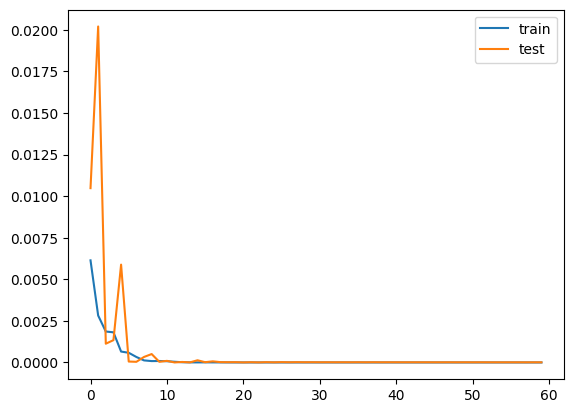

In [88]:
# Train the model
history = model.fit(X, y, epochs=60, batch_size=16, validation_split=0.2, verbose=1)

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [89]:
predictions = model.predict(X)

predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform([y])

rmse = np.sqrt(mean_squared_error(actuals[0], predictions[:,0]))
print(f'RMSE: {rmse}')

model.save('solar_power_lstm.keras')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
RMSE: 0.1421003958116185


In [85]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('solar_power_lstm.keras')  # Update the path to where your model is saved

# Scale and prepare the last 24 hours of data
recent_data_scaled = scaler.transform(df['Power (MW)'].tail(24).values.reshape(-1, 1))
recent_data_scaled = recent_data_scaled.reshape(1, 24, 1)

predictions = []
current_batch = recent_data_scaled

# Predict iteratively
for i in range(24):  # Predict the next 24 hours
    current_pred = model.predict(current_batch)[0]  # Predict the next hour
    predictions.append(current_pred)  # Store the prediction
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)  # Update the batch to include the new prediction

# Inverse scale predictions
predicted_original = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Print or store the predictions
predicted_times = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')
predicted_df = pd.DataFrame(data=predicted_original.flatten(), index=predicted_times, columns=['Predicted Power (MW)'])
print(predicted_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
                     Predicted Power (MW)
2023-12-31 01:00:00             65.896912
2023-12-31 0

/var/folders/4n/cyw2bn_96cv6fhpjgbhbl1wc0000gn/T/ipykernel_23666/215734023.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  predicted_times = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')
